In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.cuda.amp import autocast, GradScaler

In [2]:
df = pd.read_csv("/kaggle/input/house-a/house_a_combined_dataset.csv")

In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
sc = StandardScaler()
data = df.values
data = sc.fit_transform(data)  

In [6]:
from joblib import dump
dump(sc, "/kaggle/working/standardscaler_ha.joblib")

['/kaggle/working/standardscaler_ha.joblib']

In [7]:
data_tensor = torch.tensor(data, dtype=torch.float32)

In [8]:
seq_len = 600  
input_size = 25 
hidden_size = 256 
batch_size = 1024 

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) // self.seq_len  # Number of sequences
    
    def __getitem__(self, idx):
        start_idx = idx * self.seq_len
        end_idx = start_idx + self.seq_len
        return self.data[start_idx:end_idx]  # Return a sequence

In [10]:
dataset = TimeSeriesDataset(data_tensor, seq_len)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers=2):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.hidden_size = hidden_size
        self.seq_len = seq_len

    def forward(self, x):
        h0 = torch.zeros(self.encoder.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.encoder.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Pass through encoder
        encoded, (hn, cn) = self.encoder(x, (h0, c0))
        
        # Pass through decoder
        decoded, _ = self.decoder(encoded, (hn, cn))
        
        # Map decoded output back to input size
        decoded = self.output_layer(decoded)
        
        return decoded

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM_Autoencoder(input_size=input_size, hidden_size=hidden_size, seq_len=seq_len,num_layers=2).to(device)

In [13]:
model = nn.DataParallel(model)
model = model.to(device)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()

/tmp/ipykernel_30/1176063683.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [15]:
num_epochs = 500  
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch_data in enumerate(data_loader):
        batch_data = batch_data.to(device)
        with autocast():
            output = model(batch_data)
            loss = criterion(output, batch_data)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()  
        optimizer.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

/tmp/ipykernel_30/3113628587.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [10/500], Loss: 0.3366
Epoch [20/500], Loss: 0.1355
Epoch [30/500], Loss: 0.0512
Epoch [40/500], Loss: 0.0254
Epoch [50/500], Loss: 0.0168
Epoch [60/500], Loss: 0.0114
Epoch [70/500], Loss: 0.0084
Epoch [80/500], Loss: 0.0069
Epoch [90/500], Loss: 0.0077
Epoch [100/500], Loss: 0.0054
Epoch [110/500], Loss: 0.0044
Epoch [120/500], Loss: 0.0034
Epoch [130/500], Loss: 0.0028
Epoch [140/500], Loss: 0.0026
Epoch [150/500], Loss: 0.0023
Epoch [160/500], Loss: 0.0019
Epoch [170/500], Loss: 0.0019
Epoch [180/500], Loss: 0.0022
Epoch [190/500], Loss: 0.0023
Epoch [200/500], Loss: 0.0013
Epoch [210/500], Loss: 0.0012
Epoch [220/500], Loss: 0.0012
Epoch [230/500], Loss: 0.0011
Epoch [240/500], Loss: 0.0012
Epoch [250/500], Loss: 0.0010
Epoch [260/500], Loss: 0.0009
Epoch [270/500], Loss: 0.0008
Epoch [280/500], Loss: 0.0007
Epoch [290/500], Loss: 0.0008
Epoch [300/500], Loss: 0.0007
Epoch [310/500], Loss: 0.0007
Epoch [320/500], Loss: 0.0006
Epoch [330/500], Loss: 0.0007
Epoch [340/500], Lo

In [16]:
import torch.nn.functional as F
import numpy as np

reconstruction_errors_all = []
with torch.no_grad():
    for batch_idx, batch_data in enumerate(data_loader):
        batch_data = batch_data.to(device)
        reconstructed_data = model(batch_data)
        mse_loss = F.mse_loss(reconstructed_data, batch_data, reduction='none')
        mse_loss = mse_loss.view(mse_loss.size(0), -1)
        batch_reconstruction_errors = mse_loss.sum(dim=1).cpu().numpy()
        reconstruction_errors_all.extend(batch_reconstruction_errors)


In [17]:
reconstruction_errors_all = np.array(reconstruction_errors_all)
expected_length = len(df)
if len(reconstruction_errors_all) > expected_length:
    reconstruction_errors_all = reconstruction_errors_all[:expected_length]
elif len(reconstruction_errors_all) < expected_length:
    reconstruction_errors_all = np.tile(reconstruction_errors_all, (expected_length // len(reconstruction_errors_all)) + 1)[:expected_length]
threshold = np.percentile(reconstruction_errors_all, 95)
anomalies = reconstruction_errors_all > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

Number of anomalies detected: 129600


In [18]:
df['Anomaly'] = anomalies
total_samples = len(df)
anomaly_percentage = (np.sum(anomalies) / total_samples) * 100
print(f"Anomaly Percentage: {anomaly_percentage:.2f}%")

Anomaly Percentage: 5.00%


In [19]:
df.to_csv("/kaggle/working/data_with_anomalies_ha.csv", index=False)
np.save("/kaggle/working/reconstruction_errors_ha.npy", reconstruction_errors_all)
torch.save(model.state_dict(), "/kaggle/working/lstm_autoencoder_ha.pth")

<h2>Testing it on Random Data</h2>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from joblib import load

class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers=2):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.hidden_size = hidden_size
        self.seq_len = seq_len

    def forward(self, x):
        h0 = torch.zeros(self.encoder.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.encoder.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        encoded, (hn, cn) = self.encoder(x, (h0, c0))
        
        decoded, _ = self.decoder(encoded, (hn, cn))
        
        decoded = self.output_layer(decoded)
        
        return decoded

In [ ]:
model_path = "/kaggle/working/lstm_autoencoder_ha.pth"
scaler_path = "/kaggle/working/standardscaler_ha.joblib"
reconstruction_error_path = "/kaggle/working/reconstruction_errors_ha.npy"

seq_len = 600  
input_size = 25  
hidden_size = 256  
batch_size = 1024  
num_layers = 2

model = LSTM_Autoencoder(input_size=input_size, hidden_size=hidden_size, seq_len=seq_len, num_layers=num_layers)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model) 

model = model.to(device)

Using 2 GPUs


In [23]:
state_dict = torch.load(model_path, map_location=device)

if not any(key.startswith("module.") for key in state_dict.keys()):
    state_dict = {f"module.{key}": value for key, value in state_dict.items()}

try:
    model.load_state_dict(state_dict)
    print("Model loaded successfully!")
except RuntimeError as e:
    print(f"Error loading model: {e}")
    print("Ensure the model architecture matches the saved state_dict structure.")

model.eval()

Model loaded successfully!


/tmp/ipykernel_30/3335474394.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


DataParallel(
  (module): LSTM_Autoencoder(
    (encoder): LSTM(25, 256, num_layers=2, batch_first=True)
    (decoder): LSTM(256, 256, num_layers=2, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=25, bias=True)
  )
)

In [24]:
sc = load(scaler_path)
reconstruction_errors = np.load(reconstruction_error_path)

new_data = np.array([[1]*25])  
new_data = sc.transform(new_data) 

new_data_tensor = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, seq_len, input_size)

with torch.no_grad():
    new_data_reconstructed = model(new_data_tensor)
    reconstruction_error = torch.mean((new_data_tensor - new_data_reconstructed) ** 2).item()

threshold = np.percentile(reconstruction_errors, 95)  # Assuming you use the 95th percentile for anomaly threshold
is_anomaly = reconstruction_error > threshold

print(f"Threshold is = {threshold}")
print(f"Reconstruction Error: {reconstruction_error}, Anomaly: {is_anomaly}")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Threshold is = 17.74327554702716
Reconstruction Error: 193.3425750732422, Anomaly: True


In [25]:
print(f"Min error = {np.min(reconstruction_errors)} , Max Error  = {np.max(reconstruction_errors)}")

Min error = 0.3007684648036957 , Max Error  = 326.25567626953125


23


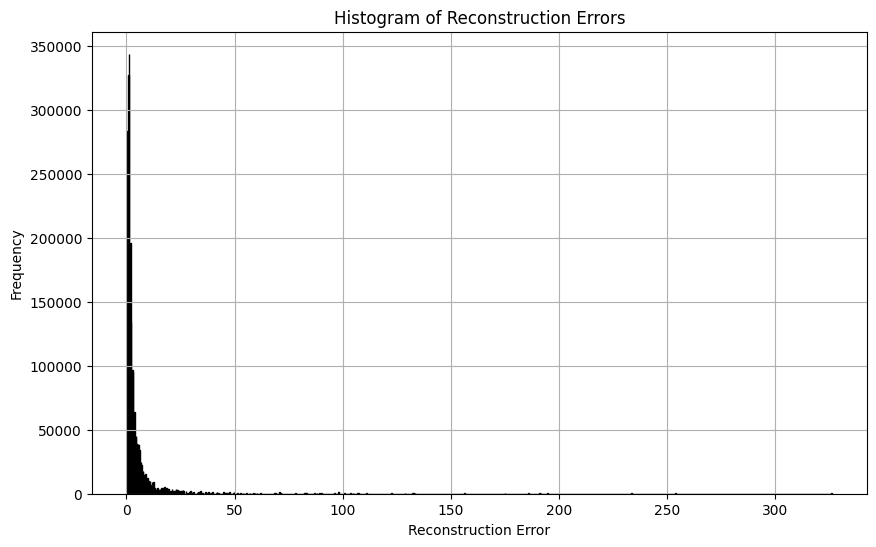

In [26]:
import matplotlib.pyplot as plt
import numpy as np


bins = np.ceil(np.log2(len(reconstruction_errors)) + 1).astype(int)
print(bins)

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=1000, color='blue', edgecolor='black')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
